Image feature extraction is the task of extracting semantically meaningful features given an image. This has many use cases, including image similarity and image retrieval. Moreover, most computer vision models can be used for image feature extraction, where one can remove the task-specific head (image classification, object detection etc) and get the features. These features are very useful on a higher level: edge detection, corner detection and so on. They may also contain information about the real world (e.g. what a cat looks like) depending on how deep the model is. Therefore, these outputs can be used to train new classifiers on a specific dataset.

In this guide, we will:
- Learn to build a simple image similarity system on top of the image feature extraction pipeline.
- Accomplish image feature extraction with bare model inference.

# Libraries

In [1]:
import torch
import requests
import numpy as np
from PIL import Image
from transformers import pipeline
from torch.nn.functional import cosine_similarity

2024-10-09 21:38:19.279064: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Image feature extraction using pipeline

In [2]:
# Load two images of cats sitting on top of fish nets
# One image is real and the other AI-generated
img_urls = ["https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png", "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.jpeg"]
image_real = Image.open(requests.get(img_urls[0], stream=True).raw).convert("RGB")
image_gen = Image.open(requests.get(img_urls[1], stream=True).raw).convert("RGB")

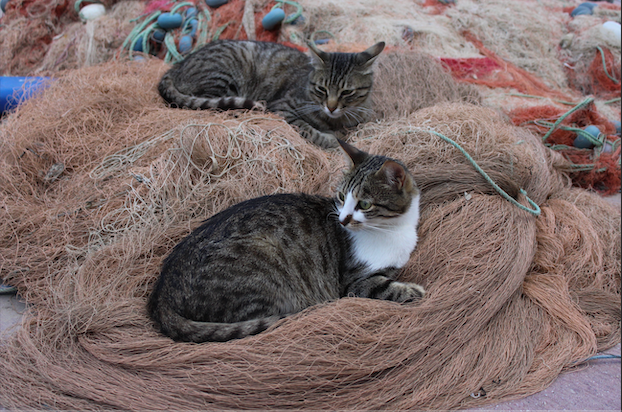

In [3]:
# Real image
image_real

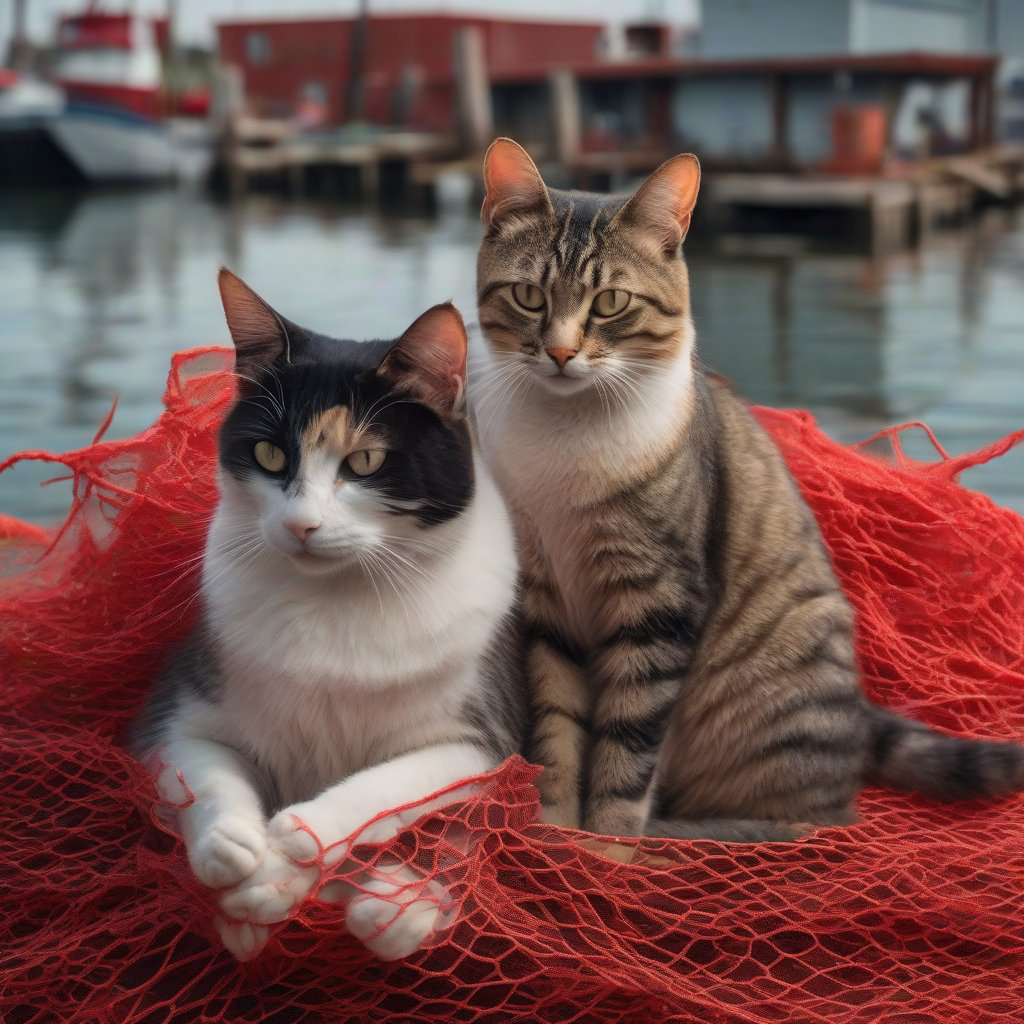

In [4]:
# AI-generated image
image_gen

In [5]:
# Instantiate pipeline. Model defaults to google/vit-base-patch16-224 if none specified
# If you’d like to calculate similarity, set pool to True
mps_device = torch.device("mps")
pipe = pipeline(task="image-feature-extraction", 
                device=mps_device, 
                pool=True)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [6]:
# To run inference, pass both images to the pipeline
# The output contains pooled embeddings of those two images
outputs = pipe([image_real, image_gen])
print(np.array(outputs).shape)

(2, 1, 768)


In [7]:
# Pass the output to a similarity function to get similarity scores
similarity_score = cosine_similarity(torch.Tensor(outputs[0]),
                                     torch.Tensor(outputs[1]), dim=1)

print(similarity_score)


tensor([0.5772])


In [8]:
# If you want to get the last hidden states before pooling, avoid passing any value for the pool parameter
# Also can pass one image at a time
# Hidden states are useful for training new classifiers or models based on the features from the model
pipe = pipeline(task="image-feature-extraction", device=mps_device)
output = pipe(image_real)

# The outputs are unpooled, 
# We get the last hidden states: first dimension is the batch size, and the last two are the embedding shape
print(np.array(output).shape)

No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


(1, 197, 768)
